# Finetune with DPO with inference data with Temperature 0.0

In [3]:
# common

# common imports
import sys
from pathlib import Path
from typing import Any, Callable, Dict, Literal, Optional, Protocol, Tuple, List

import json

sys.path.insert(0, "/workspace/code")
from otgpt_hft.data_model.serial.store import Store
from otgpt_hft.data_model.serial.entry import SerializedEntry
from otgpt_hft.data_model.source import OAnnoSource


# common paths
data_dir = Path("/workspace/data")

## Train Data Prep

In [4]:
# Load data store
dataset_name = "Thaweewat-oasst1_th"
split = "train"

data_split_dir = data_dir / f"store/{dataset_name}/{split}"
store = Store(SerializedEntry, data_split_dir)
await store.load_chunks()

In [5]:
temp = 0.3
temp_f = str(temp).replace(".", "_")

In [6]:
# temp = 0.9
# temp_f = str(temp).replace(".", "_")

In [7]:
# Load inference
raw_infer_path = data_dir/f"inference/llama2-7b-finetune-hf/Thaweewat-oasst1_th/train/temp-{temp_f}.jsonl"

with open(raw_infer_path) as file:
    raw_inference = [json.loads(e) for e in file.read().splitlines()]

In [9]:
# inference output is after END_OF_INSTRUCT markup
END_OF_INSTRUCT = "[/INST]"
EOI_OFFSET = len(END_OF_INSTRUCT)

def extract_model_output_after_instruct(infer_out: str):
    assert infer_out.count(END_OF_INSTRUCT) == 1
    infer_out_no_prompt = infer_out[infer_out.index(END_OF_INSTRUCT) + EOI_OFFSET:]
    return infer_out_no_prompt
    

In [10]:
# prep training data as dict
training_entries: List[Dict[str,str]] = []

for raw_infer in raw_inference:
    entry_id = raw_infer["id"]

    # get inference
    infer_out = raw_infer["out"]
    infer_out_no_prompt = extract_model_output_after_instruct(infer_out)
    
    # get relavent data entry in store
    s_entry = store.get(entry_id)
    
    prompt = s_entry.prompt.get_utt()
    
    for utt in s_entry.utterance:
        # SKIP `utt` NOT part of reference annotation
        if not isinstance(utt.source, OAnnoSource):
            continue

        good = utt.get_utt()

        train_entry = {
            "prompt": prompt,
            "good": good,
            "bad": infer_out_no_prompt,
        }
        training_entries.append(train_entry)

### Data Inspection

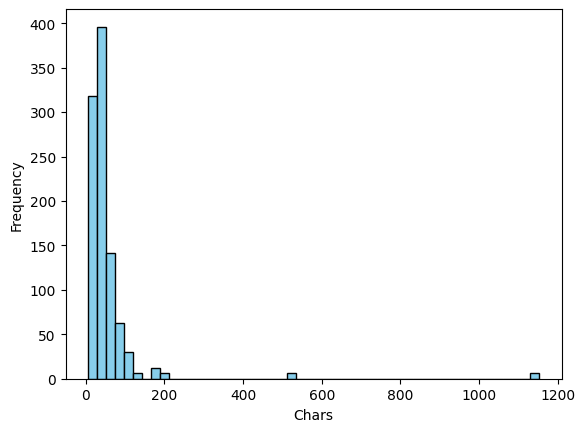

In [11]:
# check to see prompt length will fit?
# [ANS] yes
# Training context window in 2K tokens, prompt are at most 1.2K characters

prompt_len = []
for e in training_entries:
    prompt_len.append(len(e["prompt"]))

import matplotlib.pyplot as plt
import numpy as np

# Generate random data for the histogram
# data = np.random.randn(1000)

# Plotting a basic histogram
plt.hist(prompt_len, bins=50, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Chars')
plt.ylabel('Frequency')

# Display the plot
plt.show()


In [12]:
len(training_entries)

984

In [13]:
output_path = data_dir / f"training/temp-{temp_f}-v-all-ref.jsonl"

In [14]:
output_path

PosixPath('/workspace/data/training/temp-0_9-v-all-ref.jsonl')

In [15]:
# save data into training format

with open(output_path, "w") as file:
    for entry in training_entries:
        file.write(json.dumps(entry, ensure_ascii=False))
        file.write("\n")

## Training 

Training notes

#### Temp 0.3

```
source 002-001-dpo-temp-0_3-v-all-ref.sh
```

./wandb/offline-run-20240202_185047-emgq05qy/logs

Bellow are evaluation at every 2 steps
```
{'eval_loss': 0.3782382905483246, 'eval_runtime': 22.7648, 'eval_samples_per_second': 4.349, 'eval_steps_per_second': 4.349, 'eval_rewards/chosen': 0.17204105854034424, 'eval_rewards/rejected': -5.762171745300293, 'eval_rewards/accuracies': 0.6565656661987305, 'eval_rewards/margins': 5.934212684631348, 'eval_logps/rejected': -212.18138122558594, 'eval_logps/chosen': -155.55233764648438, 'eval_logits{'eval_loss': 0.1804571896791458, 'eval_runtime': 22.8754, 'eval_samples_per_second': 4.328, 'eval_steps_per_second': 4.328, 'eval_rewards/chosen': 2.144317865371704, 'eval_rewards/rejected': -12.926628112792969, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.07094669342041, 'eval_logps/rejected': -283.825927734375, 'eval_logps/chosen': -135.82958984375, 'eval_logits/rejected': -2.265436887741089, 'eval_logits/chosen': -2.2085320949554443, 'epoch': 1.73}
{'eval_loss': 0.18257048726081848, 'eval_runtime': 22.8651, 'eval_samples_per_second': 4.33, 'eval_steps_per_second': 4.33, 'eval_rewards/chosen': 2.0242137908935547, 'eval_rewards/rejected': -13.299287796020508, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.323501586914062, 'eval_logps/rejected': -287.55255126953125, 'eval_logps/chosen': -137.03062438964844, 'eval_logits/rejected': -2.281282901763916, 'eval_logits/chosen': -2.257986068725586, 'epoch': 2.02}
{'eval_loss': 0.18308402597904205, 'eval_runtime': 22.8626, 'eval_samples_per_second': 4.33, 'eval_steps_per_second': 4.33, 'eval_rewards/chosen': 1.7377803325653076, 'eval_rewards/rejected': -13.790324211120605, 'eval_rewards/accuracies': 0.7676767706871033, 'eval_rewards/margins': 15.528104782104492, 'eval_logps/rejected': -292.462890625, 'eval_logps/chosen': -139.8949432373047, 'eval_logits/rejected': -2.2867624759674072, 'eval_logits/chosen': -2.2792067527770996, 'epoch': 2.31}
{'eval_loss': 0.18331560492515564, 'eval_runtime': 22.8673, 'eval_samples_per_second': 4.329, 'eval_steps_per_second': 4.329, 'eval_rewards/chosen': 1.6265597343444824, 'eval_rewards/rejected': -13.981979370117188, 'eval_rewards/accuracies': 0.7676767706871033, 'eval_rewards/margins': 15.608540534973145, 'eval_logps/rejected': -294.37945556640625, 'eval_logps/chosen': -141.0071563720703, 'eval_logits/rejected': -2.265042304992676, 'eval_logits/chosen': -2.231825113296509, 'epoch': 2.59}
{'loss': 0.1446, 'learning_rate': 5.000000000000003e-06, 'rewards/chosen': 2.9057955741882324, 'rewards/rejected': -14.417503356933594, 'rewards/accuracies': 0.7917187809944153, 'rewards/margins': 17.323299407958984, 'logps/rejected': -290.21917724609375, 'logps/chosen': -154.30982971191406, 'logits/rejected': -2.409827947616577, 'logits/chosen': -2.435296058654785, 'epoch': 2.88}
{'eval_loss': 0.18342168629169464, 'eval_runtime': 22.8663, 'eval_samples_per_second': 4.33, 'eval_steps_per_second': 4.33, 'eval_rewards/chosen': 1.5728603601455688, 'eval_rewards/rejected': -14.05177116394043, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.624629974365234, 'eval_logps/rejected': -295.0773620605469, 'eval_logps/chosen': -141.54415893554688, 'eval_logits/rejected': -2.2794528007507324, 'eval_logits/chosen': -2.270761251449585, 'epoch': 2.88}

{'eval_loss': 0.1804571896791458, 'eval_runtime': 22.8754, 'eval_samples_per_second': 4.328, 'eval_steps_per_second': 4.328, 'eval_rewards/chosen': 2.144317865371704, 'eval_rewards/rejected': -12.926628112792969, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.07094669342041, 'eval_logps/rejected': -283.825927734375, 'eval_logps/chosen': -135.82958984375, 'eval_logits/rejected': -2.265436887741089, 'eval_logits/chosen': -2.2085320949554443, 'epoch': 1.73}
{'eval_loss': 0.18257048726081848, 'eval_runtime': 22.8651, 'eval_samples_per_second': 4.33, 'eval_steps_per_second': 4.33, 'eval_rewards/chosen': 2.0242137908935547, 'eval_rewards/rejected': -13.299287796020508, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.323501586914062, 'eval_logps/rejected': -287.55255126953125, 'eval_logps/chosen': -137.03062438964844, 'eval_logits/rejected': -2.281282901763916, 'eval_logits/chosen': -2.257986068725586, 'epoch': 2.02}
{'eval_loss': 0.18308402597904205, 'eval_runtime': 22.8626, 'eval_samples_per_second': 4.33, 'eval_steps_per_second': 4.33, 'eval_rewards/chosen': 1.7377803325653076, 'eval_rewards/rejected': -13.790324211120605, 'eval_rewards/accuracies': 0.7676767706871033, 'eval_rewards/margins': 15.528104782104492, 'eval_logps/rejected': -292.462890625, 'eval_logps/chosen': -139.8949432373047, 'eval_logits/rejected': -2.2867624759674072, 'eval_logits/chosen': -2.2792067527770996, 'epoch': 2.31}
{'eval_loss': 0.18331560492515564, 'eval_runtime': 22.8673, 'eval_samples_per_second': 4.329, 'eval_steps_per_second': 4.329, 'eval_rewards/chosen': 1.6265597343444824, 'eval_rewards/rejected': -13.981979370117188, 'eval_rewards/accuracies': 0.7676767706871033, 'eval_rewards/margins': 15.608540534973145, 'eval_logps/rejected': -294.37945556640625, 'eval_logps/chosen': -141.0071563720703, 'eval_logits/rejected': -2.265042304992676, 'eval_logits/chosen': -2.231825113296509, 'epoch': 2.59}
{'loss': 0.1446, 'learning_rate': 5.000000000000003e-06, 'rewards/chosen': 2.9057955741882324, 'rewards/rejected': -14.417503356933594, 'rewards/accuracies': 0.7917187809944153, 'rewards/margins': 17.323299407958984, 'logps/rejected': -290.21917724609375, 'logps/chosen': -154.30982971191406, 'logits/rejected': -2.409827947616577, 'logits/chosen': -2.435296058654785, 'epoch': 2.88}
{'eval_loss': 0.18342168629169464, 'eval_runtime': 22.8663, 'eval_samples_per_second': 4.33, 'eval_steps_per_second': 4.33, 'eval_rewards/chosen': 1.5728603601455688, 'eval_rewards/rejected': -14.05177116394043, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.624629974365234, 'eval_logps/rejected': -295.0773620605469, 'eval_logps/chosen': -141.54415893554688, 'eval_logits/rejected': -2.2794528007507324, 'eval_logits/chosen': -2.270761251449585, 'epoch': 2.88}
{'eval_loss': 0.18257048726081848, 'eval_runtime': 22.8651, 'eval_samples_per_second': 4.33, 'eval_steps_per_second': 4.33, 'eval_rewards/chosen': 2.0242137908935547, 'eval_rewards/rejected': -13.299287796020508, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.323501586914062, 'eval_logps/rejected': -287.55255126953125, 'eval_logps/chosen': -137.03062438964844, 'eval_logits/rejected': -2.281282901763916, 'eval_logits/chosen': -2.257986068725586, 'epoch': 2.02}
{'eval_loss': 0.18308402597904205, 'eval_runtime': 22.8626, 'eval_samples_per_second': 4.33, 'eval_steps_per_second': 4.33, 'eval_rewards/chosen': 1.7377803325653076, 'eval_rewards/rejected': -13.790324211120605, 'eval_rewards/accuracies': 0.7676767706871033, 'eval_rewards/margins': 15.528104782104492, 'eval_logps/rejected': -292.462890625, 'eval_logps/chosen': -139.8949432373047, 'eval_logits/rejected': -2.2867624759674072, 'eval_logits/chosen': -2.2792067527770996, 'epoch': 2.31}
{'eval_loss': 0.18331560492515564, 'eval_runtime': 22.8673, 'eval_samples_per_second': 4.329, 'eval_steps_per_second': 4.329, 'eval_rewards/chosen': 1.6265597343444824, 'eval_rewards/rejected': -13.981979370117188, 'eval_rewards/accuracies': 0.7676767706871033, 'eval_rewards/margins': 15.608540534973145, 'eval_logps/rejected': -294.37945556640625, 'eval_logps/chosen': -141.0071563720703, 'eval_logits/rejected': -2.265042304992676, 'eval_logits/chosen': -2.231825113296509, 'epoch': 2.59}
{'loss': 0.1446, 'learning_rate': 5.000000000000003e-06, 'rewards/chosen': 2.9057955741882324, 'rewards/rejected': -14.417503356933594, 'rewards/accuracies': 0.7917187809944153, 'rewards/margins': 17.323299407958984, 'logps/rejected': -290.21917724609375, 'logps/chosen': -154.30982971191406, 'logits/rejected': -2.409827947616577, 'logits/chosen': -2.435296058654785, 'epoch': 2.88}
{'eval_loss': 0.18342168629169464, 'eval_runtime': 22.8663, 'eval_samples_per_second': 4.33, 'eval_steps_per_second': 4.33, 'eval_rewards/chosen': 1.5728603601455688, 'eval_rewards/rejected': -14.05177116394043, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.624629974365234, 'eval_logps/rejected': -295.0773620605469, 'eval_logps/chosen': -141.54415893554688, 'eval_logits/rejected': -2.2794528007507324, 'eval_logits/chosen': -2.270761251449585, 'epoch': 2.88}
{'eval_loss': 0.18370915949344635, 'eval_runtime': 22.8707, 'eval_samples_per_second': 4.329, 'eval_steps_per_second': 4.329, 'eval_rewards/chosen': 1.5577466487884521, 'eval_rewards/rejected': -14.084894180297852, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.642640113830566, 'eval_logps/rejected': -295.4085693359375, 'eval_logps/chosen': -141.69529724121094, 'eval_logit{'eval_loss': 0.18370915949344635, 'eval_runtime': 22.8707, 'eval_samples_per_second': 4.329, 'eval_steps_per_second': 4.329, 'eval_rewards/chosen': 1.5577466487884521, 'eval_rewards/rejected': -14.084894180297852, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.642640113830566, 'eval_logps/rejected': -295.4085693359375, 'eval_logps/chosen': -141.69529724121094, 'eval_logits/rejected': -2.2741928100585938, 'eval_logits/chosen': -2.254714012145996, 'epoch': 3.17}
{'eval_loss': 0.18353240191936493, 'eval_runtime': 22.8536, 'eval_samples_per_second': 4.332, 'eval_steps_per_second': 4.332, 'eval_rewards/chosen': 1.5713255405426025, 'eval_rewards/rejected': -14.084232330322266, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.655559539794922, 'eval_logps/rejected': -295.4019775390625, 'eval_logps/chosen': -141.5594940185547, 'eval_logits/rejected': -2.2800614833831787, 'eval_logits/chosen': -2.269023895263672, 'epoch': 3.46}
{'eval_loss': 0.18386158347129822, 'eval_runtime': 22.8511, 'eval_samples_per_second': 4.332, 'eval_steps_per_second': 4.332, 'eval_rewards/chosen': 1.562206506729126, 'eval_rewards/rejected': -14.094626426696777, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.656834602355957, 'eval_logps/rejected': -295.5059509277344, 'eval_logps/chosen': -141.65069580078125, 'eval_logits/rejected': -2.275632381439209, 'eval_logits/chosen': -2.255336046218872, 'epoch': 3.75}
{'eval_loss': 0.18382926285266876, 'eval_runtime': 22.829, 'eval_samples_per_second': 4.337, 'eval_steps_per_second': 4.337, 'eval_rewards/chosen': 1.5691990852355957, 'eval_rewards/rejected': -14.0812406539917, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.65043830871582, 'eval_logps/rejected': -295.3720397949219, 'eval_logps/chosen': -141.58078002929688, 'eval_logits/rejected': -2.2705047130584717, 'eval_logits/chosen': -2.2465403079986572, 'epoch': 4.04}
{'loss': 0.1495, 'learning_rate': 0.0, 'rewards/chosen': 2.5688283443450928, 'rewards/rejected': -15.60143756866455, 'rewards/accuracies': 0.784375011920929, 'rewards/margins': 18.170263290405273, 'logps/rejected': -306.6189880371094, 'logps/chosen': -159.20986938476562, 'logits/rejected': -2.418408155441284, 'logits/chosen': -2.4488136768341064, 'epoch': 4.32}
{'eval_loss': 0.18365532159805298, 'eval_runtime': 22.8213, 'eval_samples_per_second': 4.338, 'eval_steps_per_second': 4.338, 'eval_rewards/chosen': 1.5621469020843506, 'eval_rewards/rejected': -14.078760147094727, 'eval_rewards/accuracies': 0.7575757503509521, 'eval_rewards/margins': 15.64090633392334, 'eval_logps/rejected': -295.3472595214844, 'eval_logps/chosen': -141.6512908935547, 'eval_logits/rejected': -2.277946710586548, 'eval_logits/chosen': -2.2629146575927734, 'epoch': 4.32}
{'train_runtime': 3674.4337, 'train_samples_per_second': 1.204, 'train_steps_per_second': 0.008, 'train_loss': 0.21332887013753254, 'epoch': 4.32}

wandb: 
wandb: Run history:
wandb:             eval/logits/chosen ▆▃▁▂▄█▆▄▇▅▆▅▆▆▅
wandb:           eval/logits/rejected █▄▁▂▃▅▄▄▅▄▅▄▅▅▅
wandb:              eval/logps/chosen ▁▄▇█▇▇▆▆▅▅▅▅▅▅▅
wandb:            eval/logps/rejected █▆▅▄▂▂▂▁▁▁▁▁▁▁▁
wandb:                      eval/loss █▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:        eval/rewards/accuracies ▁██▇█▇▇██▇▇▇▇▇▇
wandb:            eval/rewards/chosen ▁▄▇█▇▇▆▆▅▅▅▅▅▅▅
wandb:           eval/rewards/margins ▁▄▅▆▇██████████
wandb:          eval/rewards/rejected █▆▅▄▂▂▂▁▁▁▁▁▁▁▁
wandb:                   eval/runtime ▁▆▆▇▇█▇▇▇▇█▇▆▅▅
wandb:        eval/samples_per_second █▃▂▂▂▁▂▂▁▂▁▂▂▄▄
wandb:          eval/steps_per_second █▃▂▂▂▁▂▂▁▂▁▂▂▄▄
wandb:                    train/epoch ▁▂▂▂▃▃▄▄▅▅▅▅▆▇▇████
wandb:              train/global_step ▁▁▂▃▃▃▃▄▅▅▅▅▆▇▇▇███
wandb:            train/learning_rate █▃▁
wandb:            train/logits/chosen ▁█▆
wandb:          train/logits/rejected ▁█▇
wandb:             train/logps/chosen ▁█▅
wandb:           train/logps/rejected █▂▁
wandb:                     train/loss █▁▁
wandb:       train/rewards/accuracies ▁█▇
wandb:           train/rewards/chosen ▁█▅
wandb:          train/rewards/margins ▁▇█
wandb:         train/rewards/rejected █▂▁
wandb:               train/total_flos ▁
wandb:               train/train_loss ▁
wandb:            train/train_runtime ▁
wandb: train/train_samples_per_second ▁
wandb:   train/train_steps_per_second ▁
wandb: 
wandb: Run summary:
wandb:             eval/logits/chosen -2.26291
wandb:           eval/logits/rejected -2.27795
wandb:              eval/logps/chosen -141.65129
wandb:            eval/logps/rejected -295.34726
wandb:                      eval/loss 0.18366
wandb:        eval/rewards/accuracies 0.75758
wandb:            eval/rewards/chosen 1.56215
wandb:           eval/rewards/margins 15.64091
wandb:          eval/rewards/rejected -14.07876
wandb:                   eval/runtime 22.8213
wandb:        eval/samples_per_second 4.338
wandb:          eval/steps_per_second 4.338
wandb:                    train/epoch 4.32
wandb:              train/global_step 30
wandb:            train/learning_rate 0.0
wandb:            train/logits/chosen -2.44881
wandb:          train/logits/rejected -2.41841
wandb:             train/logps/chosen -159.20987
wandb:           train/logps/rejected -306.61899
wandb:                     train/loss 0.1495
wandb:       train/rewards/accuracies 0.78438
wandb:           train/rewards/chosen 2.56883
wandb:          train/rewards/margins 18.17026
wandb:         train/rewards/rejected -15.60144
wandb:               train/total_flos 0.0
wandb:               train/train_loss 0.21333
wandb:            train/train_runtime 3674.4337
wandb: train/train_samples_per_second 1.204
wandb:   train/train_steps_per_second 0.008
wandb: 
```
output to `model/dpo/002-001-dpo-temp-0_3-v-all-ref`  
wandb: offline-run-20240202_185047-emgq05qy


Eval loss 
```
0.3782382905483246  (02) <--keep
0.1804571896791458  (04) <--keep, best
0.18257048726081848 (06) <--keep
0.18308402597904205
0.18331560492515564
0.18342168629169464
0.18257048726081848 (14) <--keep
0.18308402597904205
0.18331560492515564
0.18342168629169464
0.18370915949344635
0.18353240191936493
0.18386158347129822 (26)
0.18382926285266876 (28)
0.18365532159805298 (30)
```
Most promising checkpoint is 04 `model/dpo/002-001-dpo-temp-0_3-v-all-ref/checkpoint-4`

Checkpoints to keep 2, 4, 6, 14

#### Temp 0.9

```
source 002-002-dpo-temp-0_9-v-all-ref.sh | tee 002-002-dpo-temp-0_9-v-all-ref.log
```

```
0.5552696585655212  (02)
0.4190722703933716  (04)
0.34669235348701477 (06)
0.32439282536506653 (08)
0.3202556371688843  (10) <-- best
0.3211551606655121  (12)
```

Most promising checkpoint is 10 `model/dpo/002-002-dpo-temp-0_9-v-all-ref/checkpoint-10`

# EOF